# bugfixtime
Predicting how many days it would take to fix a bug, given the Jira information when the bug is filed.

## Motivation
Bugs and software develeopment are inseparable. Also, having bugs in software products implies that at least some man-hour need to be assigned to address them. According to [a study in 2002 by America's National Institute of Standards and Technology (NIST)](http://www.abeacha.com/NIST_press_release_bugs_cost.htm), software bugs cost the U.S. economy an estimated **$59.5 billion** annually, or about 0.6 percent of the gross domestic product. It is almost impossible to expect no bug at all, hence, the second best alternative appears to be knowing how much work is needed to fix them so resources can be maanged efficiently.  
This project attempts to chip away at that problem by trying to predict how many days it would take to fix a bug, given their metadata when they are filed in Jira.

## Problem Statement
The motivation above helps to frame the problem statement into the following,  
*Given the metadata of the bug filed on Jira, predict how many days it would take to close/fix it.*

## Data
The data used in this study is obtained from the research article titled [From Reports to Bug-Fix Commits: A 10 Years Dataset of Bug-Fixing Activity from 55 Apache's Open Source Projects](https://dl.acm.org/doi/10.1145/3345629.3345639) by Vieira, Da Silva, Rocha, and Gomes in 2019. The data is housed [here](https://figshare.com/articles/Replication_Package_-_PROMISE_19/8852084).  
Contained within is a dataset composed of more than 70,000 bug-fix reports from 10 years of bug-fixing activity of 55 projects from the Apache Software Foundation along with their Jira data and status.

## Data Processing
Running `mining-script.py` as specified by the README file in the research article generates 3 CSV files for each of the 55 Apache Software project. The data used in here is from the `<projectname>-full-bug-fix-dataset` file from each project.

### Importing required packages

In [1]:
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn import preprocessing
import time

### Reading the file with project names
The CSV files generated by `mining-script.py` come in the format `<projectname>-jira-bug-fix-dataset`. Hence, the list of project names is needed to read the CSV files with different project name as prefixes. This list of project name can be found in the file `projects.csv`. However, the project names in the file `projects.csv` does not match the file names exactly and some names have to be added manually.

In [2]:
# read projects.csv
projects = pd.read_csv("data/projects.csv", delimiter=";")

# format the pandas series into list
projectsnames = list(projects["Name"].sort_values())

# missing names
missingnames = ["mng",
                "mrm",
                "dirkrb",
                "dirmina",
                "fc",
                "flink",
                "oozie",
                "hadoop",
                "hbase",
                "hdfs",
                "mapreduce",
                "tap5",
                "ww",
                "yarn"]

# add missing project names
projectsnames = projectsnames + missingnames

The list above is used to create CSV paths for each project's data. Reading the CSV from paths in the list then gives the complete dataset.

In [3]:
# create a list of CSV paths for the for loop below
csvpaths = []
stopwords = ["commons", "core", "mina"]
for name in projectsnames:
    name = name.lower()
    namesplit = name.split(" ")
    namesplit  = [word for word in namesplit if word not in stopwords]
    name = "".join(namesplit)
    path = "./data/" + name + "-jira-bug-fix-dataset.csv"
    csvpaths.append(path)

# for loop to read CSV, append to a dataframe and count the number of files read
filesread = 0
bugsdf = pd.DataFrame()
for path in csvpaths:
    try:
        somecsv = pd.read_csv(path, delimiter=";")
        filesread += 1
        bugsdf = bugsdf.append(somecsv, ignore_index=True)
    except FileNotFoundError:
        continue

print("files read: %i (expect 56)" % filesread)

files read: 56 (expect 56)


## Splitting the train, validation, and test set
The dataset is split before cleaning to prevent any **leakage**. This involves creating the train set, validation set and the test set.

In [47]:
bugsdf_train, bugsdf_test = train_test_split(bugsdf, test_size=0.3, random_state=0)

In [48]:
bugsdf_train.shape

(56428, 30)

In [49]:
bugsdf_train, bugsdf_val = train_test_split(bugsdf_train, test_size=0.3, random_state=0)

In [50]:
bugsdf_train.shape

(39499, 30)

In [51]:
bugsdf_val.shape

(16929, 30)

In [52]:
bugsdf_test.shape

(24184, 30)

## Data cleaning
This section involves examining key aspects of the data such as column names and types, reformatting and cleaning them as necessary.

### Column names and type
Looking at the column names and their datatype can give a rough idea of what can be used as features for the prediction models. The details about what the columns mean can be found in the PDF accompanying the dataset.

In [10]:
# printing the column names and their data types
print(bugsdf_train.dtypes)

Project                    object
Owner                      object
Manager                    object
Category                   object
Key                        object
Priority                   object
Status                     object
Reporter                   object
Assignee                   object
Components                 object
SummaryTopWords            object
DescriptionTopWords        object
CommentsTopWords           object
CreationDate               object
ResolutionDate             object
LastUpdateDate            float64
AffectsVersions            object
FixVersions                object
NoComments                  int64
FirstCommentDate           object
LastCommentDate            object
NoWatchers                  int64
NoAttachments               int64
FirstAttachmentDate        object
LastAttachmentDate         object
NoAttachedPatches           int64
FirstAttachedPatchDate     object
LastAttachedPatchDate      object
InwardIssueLinks           object
OutwardIssueLi

Both `CreationDate` and `ResolutionDate` are objects while they should be datetime. Casting them as datetime data type.

In [11]:
bugsdf_train["CreationDate"] = pd.to_datetime(bugsdf_train["CreationDate"])
bugsdf_train["ResolutionDate"] = pd.to_datetime(bugsdf_train["ResolutionDate"])
print(bugsdf_train.loc[:,["CreationDate", "ResolutionDate"]].dtypes)

CreationDate      datetime64[ns, UTC]
ResolutionDate    datetime64[ns, UTC]
dtype: object


### Missing values
There are missing values in this dataset. This section examines which column contains missing values, and how many.

In [12]:
nantable = bugsdf_train.isna().sum()
nantable = pd.DataFrame(nantable[nantable > 0], columns = ["Missing value count"])
nantable.index.name = 'Column name'
nantable

,Missing value count
Column name,
Priority,1
Reporter,10
Assignee,4118
Components,14789
SummaryTopWords,379
DescriptionTopWords,2317
CommentsTopWords,1517
LastUpdateDate,39499
AffectsVersions,16405


Among the columns that contain NANs, the columns that will be used as features are
- Priority
- Reporter
- Components
- SummaryTopWords
- DescriptionTopWords

The missing values under these columns will have to be imputed or removed.

**"Priority" column**  
There is only a single row with missing priority value. This row will be dropped.

In [13]:
#dropping the priority row with NAN value
print("bugsdf shape before dropping NAN under 'Priority' column: %s,%s" % bugsdf_train.shape)
bugsdf_train = bugsdf_train[~bugsdf_train["Priority"].isna()]
print("bugsdf shape after dropping NAN under 'Priority' column: %s,%s" % bugsdf_train.shape)
# 1 row has been dropped

bugsdf shape before dropping NAN under 'Priority' column: 39499,30
bugsdf shape after dropping NAN under 'Priority' column: 39498,30


**"Reporter" column**  
The 22 rows with missing value under "Reporter" will be dropped as well.

In [14]:
#dropping the priority row with NAN value
print("bugsdf shape before dropping NAN under 'Reporter' column: %s,%s" % bugsdf_train.shape)
bugsdf_train = bugsdf_train[~bugsdf_train["Reporter"].isna()]
print("bugsdf shape after dropping NAN under 'Reporter' column: %s,%s" % bugsdf_train.shape)
# 10 rows has been dropped

bugsdf shape before dropping NAN under 'Reporter' column: 39498,30
bugsdf shape after dropping NAN under 'Reporter' column: 39488,30


The NANs in other columns will be addressed in the feature engineering section.

## Feature Engineering
Some features have to be created from existing feature(s). Here, the target variable `DaysToFix` is crated as well.

### Creating the target variable - DaysToFix
The time difference between `CreationDate` and `ResolutionDate` is the amount of time it took to resolve or close the bugs. 
Calculating the time to resolution. The column will be named `DaysToFix`.

In [15]:
bugsdf_train["DaysToFix"] = bugsdf_train["ResolutionDate"] - bugsdf_train["CreationDate"]
# only taking the days, ignoring the hours.
bugsdf_train["DaysToFix"] = bugsdf_train["DaysToFix"].apply(lambda x: x.days)

### Feature engineering - components
The feature "Components" may have a significant impact on the number of days taken to fix the bugs. However, there are a lot of NaNs in the column. As such, a new feature called `HasComponents` has to be created. It would be a boolean value that expresses whether or not the Jira bug has components data.

In [16]:
bugsdf_train["HasComponents"] = bugsdf_train.apply(lambda x: False if pd.isnull(x["Components"]) else True, axis=1)

Plotting `DaysToFix` by `HasComponents`

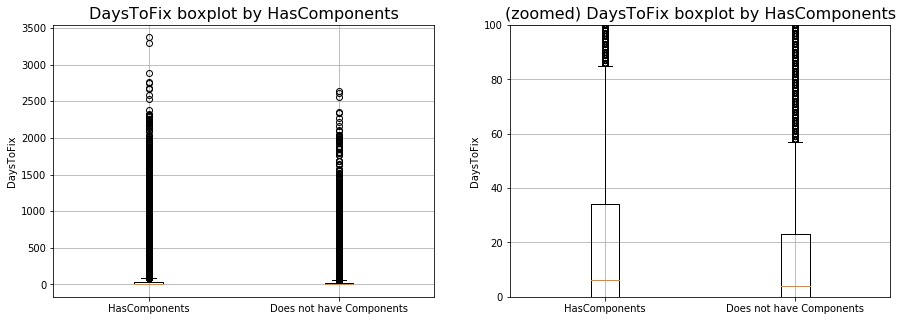

In [17]:
withcomponents = bugsdf_train[bugsdf_train["HasComponents"] == True]["DaysToFix"].values
withoutcomponents = bugsdf_train[bugsdf_train["HasComponents"] == False]["DaysToFix"].values

fig, (ax1, ax2) =  plt.subplots(1,2, figsize = (15,5))
ax1.boxplot(np.array([withcomponents, withoutcomponents]))
ax1.set_title("DaysToFix boxplot by HasComponents", fontsize=16)
ax1.set_xticklabels(['HasComponents', 'Does not have Components'])
ax1.set_ylabel("DaysToFix")
ax1.grid()

ax2.boxplot(np.array([withcomponents,withoutcomponents]))
ax2.set_ylim(0,100)
ax2.set_title("(zoomed) DaysToFix boxplot by HasComponents", fontsize=16)
ax2.set_xticklabels(['HasComponents', 'Does not have Components'])
ax2.set_ylabel("DaysToFix")
ax2.grid();

In [18]:
print("Standard deviation of DaysToFix in bugs with components array: %0.2f" % np.std(withcomponents))
print("Standard deviation of DaysToFix in bugs without components array: %0.2f" % np.std(withoutcomponents))
print("Assume normality of distribution, sufficiently similar standard deviation, and large enough sample size, \nperforming t-test:")
print(stats.ttest_ind(withcomponents, withoutcomponents, equal_var=False))

Standard deviation of DaysToFix in bugs with components array: 215.01
Standard deviation of DaysToFix in bugs without components array: 183.56
Assume normality of distribution, sufficiently similar standard deviation, and large enough sample size, 
performing t-test:
Ttest_indResult(statistic=8.160856994347808, pvalue=3.4370074556284255e-16)


The distribution of `DaysToFix` in bug with and without components are statistically different. 

### Feature engineering - bug reporter and assignee
Another feature that might affect `DaysToFix` would be if the bug reporter and assignee are the same person. That is, the reporter assigns the bug to him/herself. Another possibility would be that the bug is not assigned to anyone. The column will be called "AssignedTo" and it will have 3 possible values: 1. 'self' 2. 'other' 3. 'noone'.

In [19]:
bugsdf_train["AssignedTo"] = bugsdf_train.apply(lambda x: 'self' if x["Reporter"] == x["Assignee"]  else ('noone' if pd.isnull(x["Assignee"]) else 'other'), axis=1)

# verifying the column values
bugsdf_train.loc[15:25,["Reporter", "Assignee", "AssignedTo"]]

,Reporter,Assignee,AssignedTo
15,ittayd,lacton,other
13640,toffer,toffer,self
25332,sboikov,avinogradov,other
21374,decster,decster,self
57243,orfjackal,NaN,noone
...,...,...,...
38060,lu4242,lu4242,self
13864,v.himanshu,v.himanshu,self
57672,github-import,NaN,noone
14905,eclark,eclark,self


### Feature engineering - summary and description top words
There are 3 colums that contain information about term frequency in the summary, description, and comment section. They are called `SummaryTopWords`, `DescriptionTopWords`, and `CommentsTopWords` respectively. Since `CommentsTopWords` could be populated after the bugs were filed, this field will not be used as feature.  
The idea is to use the information available at the time the bugs were filed to predict the time it would take to fix or close the bugs. As such, only the data in `SummaryTopWords` and `DescriptionTopWords` will be used. Looking at the data in the TopWords columns,

In [20]:
# examining the columns

bugsdf_train.loc[:,["SummaryTopWords", "DescriptionTopWords", "CommentsTopWords"]].tail(10)

,SummaryTopWords,DescriptionTopWords,CommentsTopWords
56699,error:1 changing:1 password:1,web:2 http:1 error:1,snapshot:2 fact:1 critical:1 password:1 correc...
38541,implicit:1 objects:1 view:1 injected:1 using:1,inject:4 private:4 object:4 exception:4 ws:4 w...,core:5 patch:3 java:3 commit:2 available:2 x:2...
46971,error:1 due:1 invalid:1 characters:1 doc:1,error:9 unsafe:7 spark:6 java:4 media:3 data:3...,pull:4 issue:3 request:2 https:2 apache:2 spar...
7202,select:1 count:1 within:1 partition:1 respect:...,count:2 expected:1 return:1 according:1 limit:...,behavior:5 cassandra:4 think:3 limit:3 behavio...
53654,request:2 calling:1 consistent:1,requests:1 works:1,realm:4 proposed:1 solution:1 apache:1 real:1
59056,unstable:1 test:1,port:4 test:2 connections:2 error:1 following:...,apache:22 unreachable:18 test:17 java:16 local...
62984,rename:1 correctly:1 handle:1 checksum:1 files:1,file:4 destination:2 rename:1 move:1 present:1...,common:94 apache:59 java:40 patch:32 project:3...
6096,range:1 slice:1 query:1,repair:7 waiting:5 requesting:4 thread:4 resul...,cassandra:4 patches:4 fix:3 top:2 added:2 patc...
30149,cleanup:1 behavior:1,partitions:13 tasks:10 assigned:9 instance:8 o...,pull:10 commit:8 kafka:6 author:6 date:6 reque...
55750,create:1 work:1 pool:1 needed:1,nova:2 create:2 extensions:1 method:1 fails:1 ...,java:46 concurrent:18 nova:11 google:11 common...


The intended text analysis approach to be used is term frequency-inverse document frequency or TF-IDF. As such, the word-frequency pairs under the TopWords columns will have to be reformatted back into space separated strings. The content of `SummaryTopWords` and `DescriptionTopWords` will be combined.  
Writing function to generate the word bag.

In [21]:
def get_wordbag(top_words):
    '''
    Function to produce a word bag, given word-frequency pair
    args:
    top_words - a string-separated word-frequency pairs in the format <word>:<freq>
    return:
    space-separated string of words in the word bag, repeated according to their frequency
    '''
    porter = PorterStemmer()
    if pd.isnull(top_words):
        return ''
    wordlist = top_words.split(" ")
    wordlist = [pair.split(":") for pair in wordlist]
    wordbag = ""
    for word, freq in wordlist:
        for i in range(0,int(freq)):
            word = porter.stem(word)
            wordbag = wordbag + word + " "
    return wordbag[:-1]

In [22]:
# using the function above to generate space separated strings from both TopWords columns to get a word bag
t1 = time.time()
bugsdf_train["WordBag"] = bugsdf_train.apply(lambda x: get_wordbag(x["SummaryTopWords"]) + " " + get_wordbag(x["DescriptionTopWords"]), axis=1)
t2 = time.time()

print("time taken to generate word bag: %0.2f" % (t2-t1))
bugsdf_train["WordBag"][0:10]

time taken to generate word bag: 92.56


57036    check process check process ad suitabl leeway ...
37678    return escap text rather text text get current...
53158    handl embed document doc file java java java j...
42874    failur overs over somewhat rare fail avail ser...
58925    improv error messag invalid join join join joi...
61704    add creat time queri time time default default...
74177    track incorrectli deal replic factor replic re...
9129     behav inconsist method method fail check multi...
79934        helper method call schedul updat avoid flaki 
35661                          test flaki observ intern ci
Name: WordBag, dtype: object

## Exploratory data analysis 
Performing exploratory data analysis on the dataset and further feature engineering

### DaysToFix
Exploring the characteristics and distribution of the data under the column `DaysToFix`

In [23]:
# getting the max, min, and median of the column "DaysToFix"
print("value max: %i" % bugsdf_train["DaysToFix"].max())
print("value min: %i" % bugsdf_train["DaysToFix"].min())
print("value median: %i" % bugsdf_train["DaysToFix"].median())

value max: 3372
value min: 0
value median: 5


Histogram of **DaysToFix**

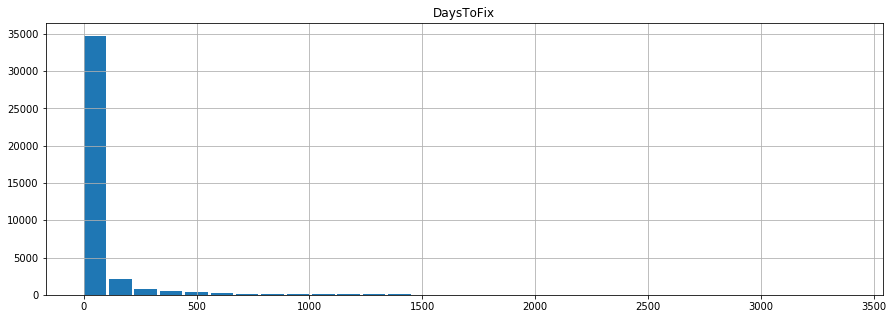

In [24]:
bugsdf_train.hist(column="DaysToFix", bins=30, figsize=(15,5), width=100);

The histogram turns the term frequency into a visualization. The very first bin has as many as ~70,000 count. The distribution of `DaysToFix` appears to be heavily skewed toward 0. Plotting the same histogram using only the third bin onward.

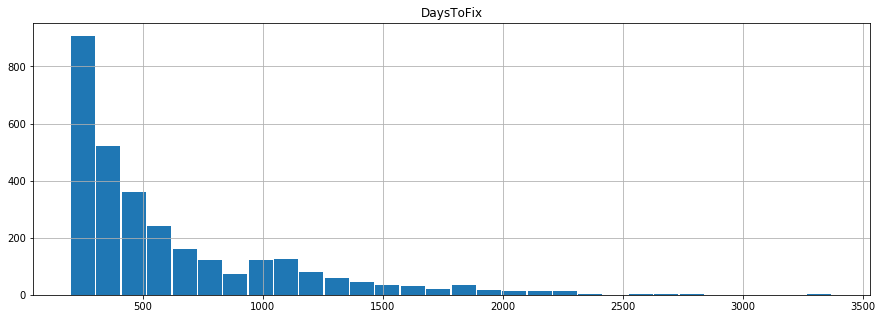

In [25]:
bugsdf_train[bugsdf_train["DaysToFix"] > 200].hist(column="DaysToFix", bins=30, figsize=(15,5), width=100);

The distribution looks to be a rather smooth decaying function with a very long tail towards extremely large `DaysToFix` values.

### DaysToFix - capping 
The target variable will be capped at 1825 days, which is 5 years. Any value above that will be set to 1825.  
The choice of capping the value at 5 years is arbitary. The only rationale behind the choice of 5 years cap is that the course of action for Apache for any bug that takes at least 5 years to fix should not differ much.

In [26]:
# capping 
bugsdf_train["DaysToFix"] = bugsdf_train["DaysToFix"].apply(lambda x: x if x <= 1825 else 1825)
bugsdf_train["DaysToFix"].max()

1825

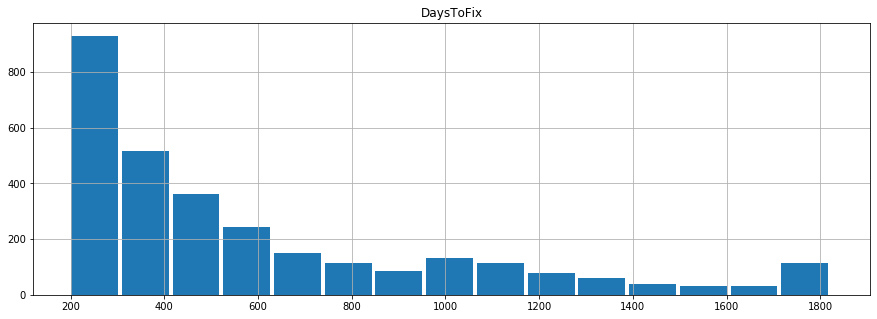

In [27]:
bugsdf_train[bugsdf_train["DaysToFix"] > 200].hist(column="DaysToFix", bins=15, figsize=(15,5), width=100);

### Project - counts
Exploring the count of each project in this dataset

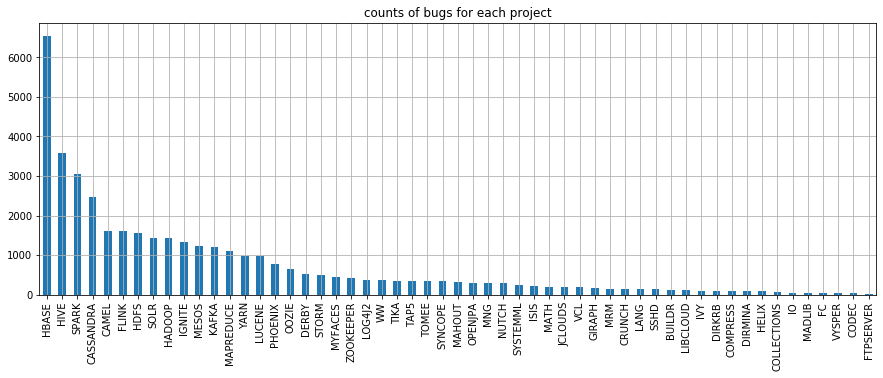

In [28]:
bugsdf_train["Project"].value_counts().plot(kind='bar',figsize=(15,5), title="counts of bugs for each project").grid()

A large number of project has relatively few bugs compared to HBASE or HIVE. However, using this as a categorical variable in the regression will lead to low sample size for each category. Another approach to classifying these bugs based on the project will have to be taken. One possible approach is using the "category" variable instead.

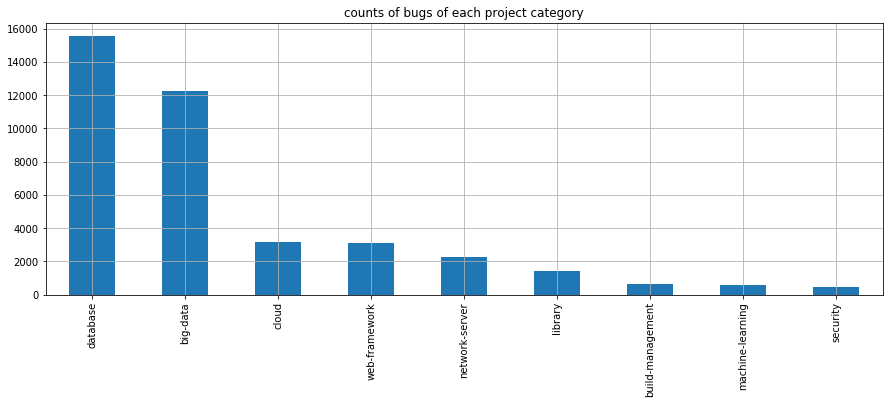

In [29]:
bugsdf_train["Category"].value_counts().plot(kind='bar',figsize=(15,5), title="counts of bugs of each project category").grid()

## Feature Engineering - text analysis
The feature `WordBag` needs further modification. The approach here is term frequency-inverse document frequency or TF-IDF. As such, the string separated data within the `WordBag` column will have to be parsed into word occurrence count and then into their TF-IDF values.

### TF-IDF
The idea is to compare the number of times the term appear in the document against the number of documents containing the term. sklearn has both count and tf-idf vectorizer that help to do this efficiently.

In [30]:
# taking the text column - WordBag
bugsdf_train_text = bugsdf_train["WordBag"].values
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
fitted_vectorizer = tfidf_vectorizer.fit(bugsdf_train_text)
bugsdf_train_text_tfidf = fitted_vectorizer.transform(bugsdf_train_text)

In [31]:
# this is a TF-IDF vector of the column 'wordbag'
print("bugsdf_train_text_tfidf's shape: %s" % (bugsdf_train_text_tfidf.shape,))

bugsdf_train_text_tfidf's shape: (39488, 7616)


The vectorizer `fitted_vectorizer` will be used to transform the validation and test set.

### SelectKBest feature selection using f-test
There are 7616 features. Only the top features that explains the most variance in f-test will be selected. sklearn has KBestSelector that does this efficiently. KBestSelector needs the TF-IDF sparse matrix, and the target variable. Hence, an array of DaysToFix value has to be created too. Selecting top 30 words that score the highest in f-test.

In [32]:
# the array of target variable
bugsdf_train_y = bugsdf_train["DaysToFix"].values

# Select top 30 words that best explain the variance of DaysToFix
KBestSelector = SelectKBest(f_regression, k=30)
bugsdf_train_text_tfidf_selected = KBestSelector.fit_transform(bugsdf_train_text_tfidf, bugsdf_train_y)
bugsdf_train_text_tfidf_selected_array = bugsdf_train_text_tfidf_selected.toarray()

The transformer `KBestSelector` will be used to transform the validation and test set.

### one-hot encoding for "Category"
"Category" is a categorical variable. This section converts eah category into its own boolean column. A True value in a column means that the sample is of that category. sklearn has `LabelBinarizer` that helps to do this efficiently. The columns are addened under the variable `onehot_names`

In [33]:
bugsdf_train_category = bugsdf_train["Category"].values
lb_category = preprocessing.LabelBinarizer()
lb_category.fit(bugsdf_train_category)
print(lb_category.classes_)
bugsdf_train_category_onehot = lb_category.transform(bugsdf_train_category)
print("bugsdf_train_category_onehot's shape: %s" % (bugsdf_train_category_onehot.shape,))
onehot_names = list(lb_category.classes_)

['big-data' 'build-management' 'cloud' 'database' 'library'
 'machine-learning' 'network-server' 'security' 'web-framework']
bugsdf_train_category_onehot's shape: (39488, 9)


### one-hot encoding for "Priority"
"Priority" is a categorical variable. This section converts eah priority class into its own boolean column. A True value in a column means that the sample is of that priority class. sklearn has LabelBinarizer that helps to do this efficiently. The columns are addened under the variable `onehot_names`

In [34]:
bugsdf_train_priority = bugsdf_train["Priority"].values
lb_priority = preprocessing.LabelBinarizer()
lb_priority.fit(bugsdf_train_priority)
print(lb_priority.classes_)
bugsdf_train_priority_onehot = lb_priority.transform(bugsdf_train_priority)
print("bugsdf_train_priority_onehot's shape: %s" % (bugsdf_train_priority_onehot.shape,))
onehot_names = onehot_names + list(lb_priority.classes_)

['Blocker' 'Critical' 'Low' 'Major' 'Minor' 'Normal' 'Trivial' 'Urgent']
bugsdf_train_priority_onehot's shape: (39488, 8)


### one-hot encoding for "AssignedTo"
"AssignedTo" is a categorical variable. This section converts eah category of `AssignedTo` into its own boolean column. A True value in a column means that the sample is of that category. sklearn has LabelBinarizer that helps to do this efficiently. The columns are addened under the variable `onehot_names`

In [35]:
bugsdf_train_assign = bugsdf_train["AssignedTo"].values
lb_assign = preprocessing.LabelBinarizer()
lb_assign.fit(bugsdf_train_assign)
print(lb_assign.classes_)
bugsdf_train_assign_onehot = lb_assign.transform(bugsdf_train_assign)
print("bugsdf_train_priority_onehot's shape: %s" % (bugsdf_train_assign_onehot.shape,))
onehot_names = onehot_names + list(lb_assign.classes_)

['noone' 'other' 'self']
bugsdf_train_priority_onehot's shape: (39488, 3)


### combining the arrays of the one-hot encodings

In [36]:
bugsdf_train_processed = np.concatenate((bugsdf_train_category_onehot,
                                    bugsdf_train_priority_onehot,
                                    bugsdf_train_assign_onehot,
                                    bugsdf_train_text_tfidf_selected_array),
                                   axis=1)
bugsdf_train_processed.shape

(39488, 50)

## Preparing validation and test set
The data has to split into test and train set. The target variable here would be the `DaysToFix` column. The feature columns are:
- Category
- Priority
- AssignedTo
- HasComponents
- Wordbag

The operations performed in the data cleaning and feature engineering process are:
- Rename `CreationDate` and `ResolutionDate`
- Drop NANs in `Priority` and `Reporter` column
- Create `HasComponents`
- Create `AssignedTo`
- Create `WordBag`
- One-hot encoding for `Category`
- One-hot encoding for `Priority`
- One-hot encoding for `AssignedTo`

Afterwards, the validation and test set will have to undergo the following transforms using transformers obtained from the train set.
- TF-IDF
- KBestSelector

Defining a function to perform all the cleaning and feature engineering steps.

In [79]:
def transformer(bugsdf, vectorizer=fitted_vectorizer, kselector=KBestSelector):
    '''
    function that converts the input df to an array of features
    '''
    # CreationDate and ResolutionDate
    bugsdf.loc[:, "CreationDate"] = pd.to_datetime(bugsdf["CreationDate"])
    bugsdf.loc[:, "ResolutionDate"] = pd.to_datetime(bugsdf["ResolutionDate"])
    
    # Drop NANs in Priority abd Reporter columns
    bugsdf = bugsdf[~bugsdf["Priority"].isna()]
    bugsdf = bugsdf[~bugsdf["Reporter"].isna()]
    
    # Create HasComponents
    bugsdf["HasComponents"] = bugsdf.apply(lambda x: False if pd.isnull(x["Components"]) else True, axis=1)
    
    # Create AssignedTo
    bugsdf["AssignedTo"] = bugsdf.apply(lambda x: 'self' if x["Reporter"] == x["Assignee"]  else ('noone' if pd.isnull(x["Assignee"]) else 'other'), axis=1)
    
    # Create WordBag
    bugsdf["WordBag"] = bugsdf.apply(lambda x: get_wordbag(x["SummaryTopWords"]) + " " + get_wordbag(x["DescriptionTopWords"]), axis=1)
    
    # One-hot encoding for Category
    bugsdf_category = bugsdf["Category"].values
    lb_category = preprocessing.LabelBinarizer()
    lb_category.fit(bugsdf_category)
    bugsdf_category_onehot = lb_category.transform(bugsdf_category)
    
    # One-hot encoding for Priority
    bugsdf_priority = bugsdf["Priority"].values
    lb_priority = preprocessing.LabelBinarizer()
    lb_priority.fit(bugsdf_priority)
    bugsdf_priority_onehot = lb_priority.transform(bugsdf_priority)
    
    # One-hot encoding for AssignedTo
    bugsdf_assign = bugsdf["AssignedTo"].values
    lb_assign = preprocessing.LabelBinarizer()
    lb_assign.fit(bugsdf_assign)
    bugsdf_assign_onehot = lb_assign.transform(bugsdf_assign)
    
    # TF-IDF
    # taking the text column - WordBag
    bugsdf_text = bugsdf["WordBag"].values
    bugsdf_text_tfidf = vectorizer.transform(bugsdf_text)
    
    # KBestSelector
    # the array of target variable
    bugsdf_y = bugsdf["DaysToFix"].values
    # Select top 30 words that best explain the variance of DaysToFix
    bugsdf_text_tfidf_selected = kselector.transform(bugsdf_text_tfidf)
    bugsdf_text_tfidf_selected_array = bugsdf_text_tfidf_selected.toarray()
    
    # combining the results above to a formatted array
    bugsdf_processed = np.concatenate((bugsdf_category_onehot,
                                    bugsdf_priority_onehot,
                                    bugsdf_assign_onehot,
                                    bugsdf_text_tfidf_selected_array),
                                   axis=1)
    
    return bugsdf_processed

Transforming the validation and test set and creating the target variable arrays

In [80]:
bugsdf_val_processed = transformer(bugsdf_val, vectorizer=fitted_vectorizer, kselector=KBestSelector)
# DaysToFix
bugsdf_val["DaysToFix"] = bugsdf["ResolutionDate"] - bugsdf["CreationDate"]
bugsdf_val.loc[:, "DaysToFix"] = bugsdf_val["DaysToFix"].apply(lambda x: x.days)
# Cap DaysToFix
bugsdf_val.loc[:, "DaysToFix"] = bugsdf_val["DaysToFix"].apply(lambda x: x if x <= 1825 else 1825)
bugsdf_val_y = bugsdf_val["DaysToFix"].values

bugsdf_test_processed = transformer(bugsdf_test, vectorizer=fitted_vectorizer, kselector=KBestSelector)
# DaysToFix
bugsdf_test["DaysToFix"] = bugsdf_test["ResolutionDate"] - bugsdf_test["CreationDate"]
bugsdf_test.loc[:, "DaysToFix"] = bugsdf_test["DaysToFix"].apply(lambda x: x.days)
# Cap DaysToFix
bugsdf_test.loc[:, "DaysToFix"] = bugsdf_test["DaysToFix"].apply(lambda x: x if x <= 1825 else 1825)
bugsdf_test_y = bugsdf_test["DaysToFix"].values

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [77]:
bugsdf_train, bugsdf_test = train_test_split(bugsdf, test_size=0.3, random_state=0)
bugsdf_train, bugsdf_val = train_test_split(bugsdf_train, test_size=0.3, random_state=0)

In [82]:
bugsdf_val["DaysToFix"]

KeyError: 'DaysToFix'

In [78]:
bugsdf_test["DaysToFix"] = bugsdf_test["ResolutionDate"] - bugsdf_test["CreationDate"]

TypeError: unsupported operand type(s) for -: 'str' and 'str'

## Model Selection
Since this is a regression problem, it is only logical to attempt a linear regression based model. In this project, the model of choice is Ridge regression or linear regression with L2 regularization. Regularized model is picked since they do not overfit as much as a traidtion linear regression model.  
Another type of model that will be attempted is a decision tree based model.  Two variants of that is a simple decision tree and an ensemble of random forest model.

### Ridge regression
Fitting an linear regression with L2 regularization to the data, using `DaysToFix` as the target variable.

|Features|Target variable|
|----|----|
|`bugsdf_train_processed`|`bugsdf_train_y`|

In [ ]:
t1 = time.time()
clf = Ridge(alpha=1.0)
clf.fit(bugsdf_train_processed, bugsdf_train_y)
t2 = time.time()
print("time taken to train ridge regression: %0.2f" % (t2-t1))
print("alpha value is 1.0")
print("score is: %0.6f" % clf.score(bugsdf_val_processed, bugsdf_val_y))
print("rmse is: %0.2f" % np.sqrt(mean_squared_error(bugsdf_val_y, clf.predict(bugsdf_val_processed))))

### Hyperparameter tuning: regularization constant

In [ ]:
c_values = [0.5,10,100,300,500,1000]
for c in c_values:
    clf = Ridge(alpha=c)
    clf.fit(bugsdf_train_processed, bugsdf_train_y)
    print("alpha value is %0.2f" % c)
    print("score is: %0.6f" % clf.score(bugsdf_val_processed, bugsdf_val_y))
    print("rmse is: %0.2f" % np.sqrt(mean_squared_error(bugsdf_val_y, clf.predict(bugsdf_val_processed))))

### Fitting the model using the best C value
Optimal value of alpha is **100**. Fitting ridge regression again and plotting the y_pred vs y_actual.

In [ ]:
t1 = time.time()
clf = Ridge(alpha=100)
clf.fit(bugsdf_train_processed, bugsdf_train_y)
t2 = time.time()
print("time taken to train ridge regression: %0.2f" % (t2-t1))
print("rmse is: %0.2f" % np.sqrt(mean_squared_error(bugsdf_val_y, clf.predict(bugsdf_val_processed))))
plt.figure(figsize=(12, 8))
plt.scatter(bugsdf_val_y, clf.predict(bugsdf_val_processed))
plt.title("Ridge reg: predicted Y vs actual Y")
plt.ylabel("predicted Y (DaysToFix)")
plt.xlabel("actual Y (DaysToFix)")
plt.grid()
plt.show()

### Decision tree regression
A single decision tree. For initial settings, max depth is set as 100 and min_samples_leaf = 50

In [ ]:
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0, max_depth=100, min_samples_leaf=50)

# fit the regressor with X and Y data 
t1 = time.time()
regressor.fit(bugsdf_train_processed, bugsdf_train_y)
t2 = time.time()
print("time taken to train decision tree regressor: %0.2f" % (t2-t1))
print("rmse is: %0.2f" % np.sqrt(mean_squared_error(bugsdf_val_y, regressor.predict(bugsdf_val_processed))))

#### hyperparameter tuning
- min_samples_leaf
- max_depth

In [ ]:
tree_depths = [50,200,400]
min_leaves = [50,100,200,300,400]
dt_rmse_vals = []
for tree_depth in tree_depths:
    for leaf in min_leaves:
        regressor = DecisionTreeRegressor(max_depth = tree_depth, min_samples_leaf = leaf, random_state = 0)
        regressor.fit(bugsdf_train_processed, bugsdf_train_y)
        print("for tree regressor max depth of: " +
              "%i and min leaf size of: %i, rmse is: %0.4f" %
              (tree_depth,
               leaf,
               np.sqrt(mean_squared_error(bugsdf_val_y, regressor.predict(bugsdf_val_processed)))))
        dt_rmse_vals.append(np.sqrt(mean_squared_error(bugsdf_val_y, regressor.predict(bugsdf_val_processed))))

plotting the errors against the tunning runs

In [ ]:
x_coordinate = [i for i in range(len(dt_rmse_vals))]
plt.figure(figsize=(12, 8))
plt.plot(x_coordinate, dt_rmse_vals)
plt.title("rmse of each grid search run - Decision Tree")
plt.ylabel("root mean squared error")
plt.xlabel("grid search runs")
plt.grid()
plt.xticks(np.arange(0,len(x_coordinate)))
plt.show()

### Fitting the model using the final depth and leaf size
The best performance appears to be when the depth is 50 and min leaf size is 100.

In [ ]:
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0, max_depth=50, min_samples_leaf=100)

# fit the regressor with X and Y data 
t1 = time.time()
regressor.fit(bugsdf_train_processed, bugsdf_train_y)
t2 = time.time()
print("time taken to train decision tree regressor: %0.2f" % (t2-t1))
print("rsme: %0.4f" % np.sqrt(mean_squared_error(bugsdf_val_y, regressor.predict(bugsdf_val_processed))))


# plotting the predicted vs actual results
plt.figure(figsize=(12, 8))
plt.scatter(bugsdf_val_y, regressor.predict(bugsdf_val_processed))
plt.title("Decision Tree: predicted Y vs actual Y")
plt.ylabel("predicted Y (DaysToFix)")
plt.xlabel("actual Y (DaysToFix)")
plt.grid()
plt.show()

### Random Forest
attempting to fit a random forest model. n_estimators is set at 100, max_depth = 10 and min_samples_leaf = 1

In [ ]:
# create regressor object 
RFregressor = RandomForestRegressor(n_estimators = 100, random_state = 0, max_depth = 10, min_samples_leaf = 1)

# fit the regressor with x and y data
t1 = time.time()
RFregressor.fit(bugsdf_train_processed, bugsdf_train_y)
t2 = time.time()
print("time taken to train random forest regression: %0.2f" % (t2-t1))
print("rmse is: %0.2f" % np.sqrt(mean_squared_error(bugsdf_val_y, RFregressor.predict(bugsdf_val_processed))))

### hyperparameter tuning
- tree_depths
- min_leaves
- n_estimators

In [ ]:
tree_depths = [10,50,200]
min_leaves = [3,10,50,100,200]
estimators = [50,100,200]
rf_rmse_vals = []
for tree_depth in tree_depths:
    for leaf in min_leaves:
        for estimator in estimators:
            RFregressor = RandomForestRegressor(n_estimators = estimator, random_state = 0, max_depth = tree_depth, min_samples_leaf = leaf)
            RFregressor.fit(bugsdf_train_processed, bugsdf_train_y)
            print("for random forest regressor max depth of:" + 
                  "%i, min leaf size of: %i, and n_estimators of: %i, rmse is: %0.2f"
                  % (tree_depth,
                     leaf,
                     estimator,
                     np.sqrt(mean_squared_error(bugsdf_val_y, RFregressor.predict(bugsdf_val_processed)))))
            rf_rmse_vals.append(np.sqrt(mean_squared_error(bugsdf_val_y, RFregressor.predict(bugsdf_val_processed))))

plotting the errors against the tuning runs

In [ ]:
x_coordinate = [i for i in range(len(rf_rmse_vals)) ]
plt.figure(figsize=(12, 8))
plt.plot(x_coordinate, rf_rmse_vals)
plt.title("rmse of each grid search run - RandomForest")
plt.ylabel("root mean squared error")
plt.xlabel("grid search runs")
plt.grid()
plt.xticks(np.arange(0,len(x_coordinate)))
plt.show()

### Fitting the models with the final parameters from hyperparameter tuning runs
- tree_depths = 10
- min_leaves = 50
- n_estimators = 200

In [ ]:
# create regressor object 
RFregressor = RandomForestRegressor(n_estimators = 200, random_state = 0, max_depth = 10, min_samples_leaf = 50)

# fit the regressor with x and y data
t1 = time.time()
RFregressor.fit(bugsdf_train_processed, bugsdf_train_y)
t2 = time.time()

print("time taken to train random forest regression: %0.2f" % (t2-t1))
print("rsme: %0.4f" % np.sqrt(mean_squared_error(bugsdf_val_y, RFregressor.predict(bugsdf_val_processed))))

# plotting the predicted vs actual results
plt.figure(figsize=(12, 8))
plt.scatter(bugsdf_val_y, RFregressor.predict(bugsdf_val_processed))
plt.title("Random forest: predicted Y vs actual Y")
plt.ylabel("predicted Y (DaysToFix)")
plt.xlabel("actual Y (DaysToFix)")
plt.grid()
plt.savefig("random-forest-predicted-actual")
plt.show()

## Discussion
None of the models offer outstanding results. The scatterplots clearly show that the predicted `DaysToFix` only agrees with the actual value of `DaysToFix` to a small extent. Random Forest model offers the lowerst error at ~186.57.  
As such, it appears that the Jira data at the time the bugs are filed alone is not sufficient at predicting the number of days it would take to fix a bug.

## Model Evaluation - Utility functions
A hypothetical scenario is used to evaluate the performance of the models.  

**The scenario**  
Apache foundation needs to address the bugs in their product.  
Every bug that gets reported must eventually be closed or resolved. In this universe, software engineers are hired on a per-contract basis. The contracts will specify the number of days they are hired for. They charge \\$100 per day for bug fixing service. Should more work is needed from them beyond the contract duration, Apache has to commission the software engineers to work overtime on the bugs at the rate of \\$150 per day.  
Apache wants to minimize the **excess** spending on hiring software engineers as  much as possible.  

**In summary**  
Framing the scenario above into a data science problem statements.
If the model under-predicts the days required to fix a bug, Apache has to commission software engineers to work overtime on the bugs at the rate of \\$150 per day.  
If the model over-predicts the days required to fix a bug, it means that Apache is paying \\$100 more than it should have.  

Hence, defining error as `{y(pred) - y(actual)}`, a positive error value should be multiplied by \\$100 while a negative error value is multiplied by \\$150.

### Calculating *excess* spending for each model
There are 4 possible ways to approach this problem 
- Using ridge regression to predict the number of days to contract software developers
- Using decision tree to predict the number of days to contract software developers
- Using random forest to predict the number of days to contract software developers
- (Assumed to be Apache's current approach) Using the mean value of DaysToFix for the number of days to contract software developers

Also, the value used to evaluate the costs will be from **test set** instead of the **validation set** used above.

In [ ]:
# Ridge regreesion
ridge_error_array = clf.predict(bugsdf_test_processed) - bugsdf_test_y
ridge_error_array = np.round(ridge_error_array)
ridge_error_array = np.where(ridge_error_array > 0, ridge_error_array * 100, ridge_error_array)
ridge_error_array = np.where(ridge_error_array < 0, ridge_error_array * -150, ridge_error_array)

# Decision tree regressor
dtree_error_array = regressor.predict(bugsdf_test_processed) - bugsdf_test_y
dtree_error_array = np.round(dtree_error_array)
dtree_error_array = np.where(dtree_error_array > 0, dtree_error_array * 100, dtree_error_array)
dtree_error_array = np.where(dtree_error_array < 0, dtree_error_array * -150, dtree_error_array)

# random forest
rf_error_array = RFregressor.predict(bugsdf_test_processed) - bugsdf_test_y
rf_error_array = np.round(rf_error_array)
rf_error_array = np.where(rf_error_array > 0, rf_error_array * 100, rf_error_array)
rf_error_array = np.where(rf_error_array < 0, rf_error_array * -150, rf_error_array)

# using mean value instead
print("mean value of DaysToFix is %i days" % round(bugsdf_train_y.mean()))
mean_val_error_array = np.full(len(bugsdf_test_y), round(bugsdf_train_y.mean())) - bugsdf_test_y
mean_val_error_array = np.where(mean_val_error_array > 0, mean_val_error_array * 100, mean_val_error_array)
mean_val_error_array = np.where(mean_val_error_array < 0, mean_val_error_array * -150, mean_val_error_array)

print("for %i bugs," % len(bugsdf_train_y))
print("total excess spending using ridge regression model: ${:,.0f}".format(sum(ridge_error_array)))
print("total excess spending using decision tree model: ${:,.0f}".format(sum(dtree_error_array)))
print("total excess spending using random forest model: ${:,.0f}".format(sum(rf_error_array)))
print("total excess spending using just the mean value (64 days): ${:,.0f}".format(sum(mean_val_error_array)))

#### Discussion
In terms of total excess spending, a simple decision tree model appears to translate to the lowest excess spending, barely beating Random Forest. In fact, it would help Apache foundation save **\\$18,974,600** if they were to switch from using the mean value to the Random Forest model.

### Limited budget
With limited budget, some bugs can be ignored. That is, Apache will not be hiring any developer to work on them at all. This way, Apache can prioritize on the bugs through its predicted `DaysToFix` value.  
Currently, Bugbash can only afford excess spending of $50 million.

In [ ]:
# getting the predictions
ridge_y_pred = clf.predict(bugsdf_test_processed)
dtree_y_pred = regressor.predict(bugsdf_test_processed)
rf_y_pred = RFregressor.predict(bugsdf_test_processed)

# sorting them and their erros(in $ cost) by the predicted value
ridge_y_pred_argsort = np.argsort(ridge_y_pred)
dtree_y_pred_argsort = np.argsort(dtree_y_pred)
rf_y_pred_argsort = np.argsort(rf_y_pred)

ridge_error_array_sorted = np.take_along_axis(ridge_error_array, ridge_y_pred_argsort, axis=0)
ridge_y_pred_sorted = np.take_along_axis(ridge_y_pred, ridge_y_pred_argsort, axis=0)
dtree_error_array_sorted = np.take_along_axis(dtree_error_array, dtree_y_pred_argsort, axis=0)
dtree_y_pred_sorted = np.take_along_axis(dtree_y_pred, dtree_y_pred_argsort, axis=0)
rf_error_array_sorted = np.take_along_axis(rf_error_array, rf_y_pred_argsort, axis=0)
rf_y_pred_sorted = np.take_along_axis(rf_y_pred, rf_y_pred_argsort, axis=0)

# cumulated cost
ridge_error_array_cumm = np.cumsum(ridge_error_array_sorted)
ridge_error_array_cumm = np.round(ridge_error_array_cumm) / 1000000
dtree_error_array_cumm = np.cumsum(dtree_error_array_sorted)
dtree_error_array_cumm = np.round(dtree_error_array_cumm) / 1000000
rf_error_array_cumm = np.cumsum(rf_error_array_sorted)
rf_error_array_cumm = np.round(rf_error_array_cumm) / 1000000

Plotting the cumulated cost against number of bugs and the `DaysToFix` value

In [ ]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(421)
ax1.scatter(np.arange(1, len(ridge_y_pred_sorted)+1), ridge_error_array_cumm, s=0.1, c='b', label='Ridge')
ax1.scatter(np.arange(1, len(dtree_y_pred_sorted)+1), dtree_error_array_cumm, s=0.1, c='r', label='Decision tree')
ax1.scatter(np.arange(1, len(rf_y_pred_sorted)+1), rf_error_array_cumm, s=0.1, c='black', label='Random forest')
ax1.axhline(50, c='r', alpha=0.5)
ax1.ticklabel_format(style='plain')
ax1.title.set_text("Ridge vs Decision Tree vs Random Forest: \ncumulative cost against number of bugs to be fixed")
ax1.set_ylabel("cumulative cost (millions)")
ax1.set_xlabel("number of bugs included")
ax1.legend(loc='upper left')
ax1.grid()

ax2 = fig.add_subplot(422)
ax2.scatter(np.arange(1, len(ridge_y_pred_sorted)+1), ridge_error_array_cumm, s=0.1, c='b', label='Ridge')
ax2.scatter(np.arange(1, len(dtree_y_pred_sorted)+1), dtree_error_array_cumm, s=0.1, c='r', label='Decision tree')
ax2.scatter(np.arange(1, len(rf_y_pred_sorted)+1), rf_error_array_cumm, s=0.1, c='black', label='Random forest')
ax2.axhline(50, c='r', alpha=0.5)
ax2.axvline(11200, c='r', alpha=0.5)
ax2.ticklabel_format(style='plain')
ax2.title.set_text("(zommed in) Ridge vs Decision Tree vs Random Forest: \ncumulative cost against number of bugs to be fixed")
ax2.set_ylabel("cumulative cost (millions)")
ax2.set_xlabel("number of bugs included")
ax2.legend(loc='upper left')
ax2.set_xlim([10000,12000])
ax2.set_ylim([40,60])
ax2.grid()

ax3 = fig.add_subplot(423)
ax3.scatter(ridge_y_pred_sorted, ridge_error_array_cumm, s=0.1, c='b', label='Ridge')
ax3.scatter(dtree_y_pred_sorted, dtree_error_array_cumm, s=0.1, c='r', label='Decision tree')
ax3.scatter(rf_y_pred_sorted, rf_error_array_cumm, s=0.1, c='black', label='Random forest')
ax3.axhline(50, c='r', alpha=0.5)
ax3.ticklabel_format(style='plain')
ax3.title.set_text("Ridge vs Decision Tree vs Random Forest: \ncumulative cost against days predicted")
ax3.set_ylabel("cumulative cost (millions)")
ax3.set_xlabel("predicted DaysToFix")
ax3.legend(loc='upper left')
ax3.grid()

ax4 = fig.add_subplot(424)
ax4.scatter(ridge_y_pred_sorted, ridge_error_array_cumm, s=0.1, c='b', label='Ridge')
ax4.scatter(dtree_y_pred_sorted, dtree_error_array_cumm, s=0.1, c='r', label='Decision tree')
ax4.scatter(rf_y_pred_sorted, rf_error_array_cumm, s=0.1, c='black', label='Random forest')
ax4.axhline(50, c='r', alpha=0.5)
ax4.axvline(35, c='r', alpha=0.5)
ax4.ticklabel_format(style='plain')
ax4.title.set_text("(zommed in) Ridge vs Decision Tree vs Random Forest: \ncumulative cost against days predicted")
ax4.set_ylabel("cumulative cost (millions)")
ax4.set_xlabel("predicted DaysToFix")
ax4.legend(loc='upper left')
ax4.set_xticks(np.arange(0,100,5))
ax4.set_xlim([0,100])
ax4.set_ylim([0,100])
ax4.grid()

plt.savefig("limited-budget-plot")
plt.show()

### Discussion
Given the limited budget of $50 million, from the top 2 graphs, using Random Forest model will allow Bugbash to address the most number of bugs. Through the bottom two chrats, keeping the excess spending below \\$50 is done through only fixing bugs with DaysToFix of 35 days or less.

## Recommendation
Using the decision tree model will help to save Apache's excess cost by **\\$18,974,600**. However, the choice of model changes if Apache has limited budget and is not fixing every bug. With a budget of \$50 million, Apache is better off using the random forest model for its `DaysToFix` prediction.  
However, this is only 7\% cost saving. As such, this is only a stopgap measure. Apache foundation needs to find a more cost effective way to fix the bugs in their product.